<a href="https://colab.research.google.com/github/caleb-code/ray-tracing-cpu-parallelized/blob/main/Simple_Ray_Tracing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
import sympy as sp
import random

In [ ]:
x, y, z, a, b, c, r, k, h, l, m, q, t, j,d  = sp.symbols("x y z a b c r k h l m q t j d")

plane = sp.Eq(r**2, (x-h)**2 + (y-k)**2 + (z-j)**2)
x = a*t+l
y = b*t+m
z = c*t+q
soln_alg = sp.solve(plane.subs(x,x).subs(y,y).subs(z,z), t)

In [ ]:
def safe_sqrt(x):
  safe_inds = np.where(x >= 0, x, np.nan)
  return np.sqrt(safe_inds)

/tmp/ipython-input-1301844874.py:93: RuntimeWarning: overflow encountered in multiply
  X = x_ray.reshape((256,256)) * ray_intersections + x
/tmp/ipython-input-1301844874.py:33: RuntimeWarning: overflow encountered in divide
  Ny = (y-self.coords[1]) / self.radius
/tmp/ipython-input-1301844874.py:34: RuntimeWarning: overflow encountered in divide
  Nz = (z-self.coords[2]) / self.radius


inf
0.5000128165145346
0.10655951499938965


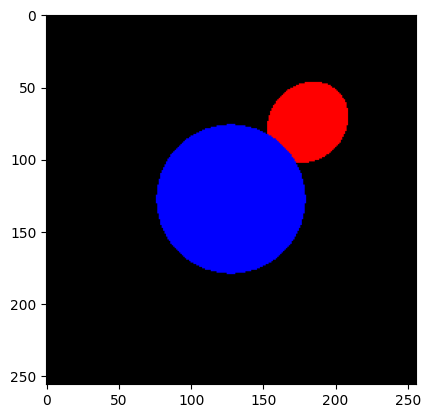

In [ ]:
class Sphere:
  def __init__(self,r,h,k,j,color,emission,reflection):
    self.radius = r
    self.coords = [h,k,j]
    self.emission = emission
    self.color = color
    self.reflection = reflection

  def pos(self):
    return self.coords, self.radius
  def line_instersect_sphere(self, a,b,c,r,h,k,j,l,m,q):
    out = np.zeros(b.shape)
    discriminant = safe_sqrt(-a**2*j**2 + 2*a**2*j*q - a**2*k**2 + 2*a**2*k*m - a**2*m**2 - a**2*q**2 + a**2*r**2 + 2*a*b*h*k - 2*a*b*h*m - 2*a*b*k*l + 2*a*b*l*m + 2*a*c*h*j - 2*a*c*h*q - 2*a*c*j*l + 2*a*c*l*q - b**2*h**2 + 2*b**2*h*l - b**2*j**2 + 2*b**2*j*q - b**2*l**2 - b**2*q**2 + b**2*r**2 + 2*b*c*j*k - 2*b*c*j*m - 2*b*c*k*q + 2*b*c*m*q - c**2*h**2 + 2*c**2*h*l - c**2*k**2 + 2*c**2*k*m - c**2*l**2 - c**2*m**2 + c**2*r**2)
    out = np.where(np.isnan(discriminant), out, np.inf)
    negative_root = ((a*h - a*l + b*k - b*m + c*j - c*q - discriminant)/(a**2 + b**2 + c**2))
    positive_root = ((a*h - a*l + b*k - b*m + c*j - c*q + discriminant)/(a**2 + b**2 + c**2))
    out = np.minimum(np.where(negative_root<=.1, np.inf, negative_root),
           np.where(positive_root<=.1, np.inf, negative_root))
    return out

  def intersect_ray(self, a, bc, lmq): # a,b,c = line slope; r = sphere radius; h,k,j = position of sphere; lmq = position of line
    b = bc[:,0]
    c = bc[:,1]
    r = self.radius
    h,k,j = self.coords
    l,m,q=lmq
    b, c = b.reshape(256*256), c.reshape(256*256)
    if type(m) == np.ndarray:
      l,m,q = l.reshape(256*256), m.reshape(256*256), q.reshape(256*256)
    return self.line_instersect_sphere(a,b,c,r,h,k,j,l,m,q)
  def calculate_normal(self, x,y,z):
    Nx = (x-self.coords[0]) / self.radius
    Ny = (y-self.coords[1]) / self.radius
    Nz = (z-self.coords[2]) / self.radius
    normals = np.stack((Nx, Ny, Nz), axis=-1)
    return normals

class Plane:
  def __init__(self,d,a,b,c,color,emission,reflection):
    self.depth = d
    self.slopes = [a,b,c]
    self.emission = emission
    self.color = color
    self.reflection = reflection
    self.normal = [a,b,c]/np.sqrt(a**2 + b**2 + c**2)
  def pos(self):
    return self.depth, self.slopes
  def intersect_ray(self, a, bc, lmq):
    k,h,j = self.slopes
    d = self.depth
    b = bc[:,0]
    c = bc[:,1]
    l,m,q = lmq
    b, c = b.reshape(256*256), c.reshape(256*256)
    if type(m) == type(np.array([0])):
      l,m,q = l.reshape(256*256), m.reshape(256*256), q.reshape(256*256)
    return (d - h*m - j*q - k*l)/(a*k + b*h + c*j)
  def calculate_normal(self, x,y,z):
    return self.normal

class View:
  grid1, grid2 = np.meshgrid(np.linspace(-1, 1, 256),np.linspace(-1, 1, 256)*-1)
  camera_view = np.stack([grid1.ravel(), grid2.ravel()], axis=1)
  master_list = []
  light_sources = []
  def __init__(self, objects):
    for i in objects:
      self.master_list.append(i)
      if i.emission:
        self.light_sources.append(i)
  def add(self, object):
    self.master_list.append(object)
  def trace_rays(self,x_ray, rays, x=0, y=0, z=0, calculate_ld = False):
    ray_intersections = np.ones((256,256)) * np.inf
    Xout = np.zeros((256,256))
    Yout = np.zeros((256,256))
    Zout = np.zeros((256,256))
    normals = np.zeros((256,256,3))
    colors = np.zeros((256,256,3))
    brightness = np.zeros((256,256))
    reflection = np.zeros((256,256))
    for i in self.master_list:
      # Find ray intersections based on an array of ray slopes {rays}, and ray origins {x,y,z}
      ray_intersection = np.nan_to_num(i.intersect_ray(x_ray, rays, [x,y,z]).reshape(256,256), nan=np.inf)
      # Replace anything found below zero with np.inf
      ray_intersection = np.where(ray_intersection < 0, np.inf, ray_intersection)
      # Find out whether the found ray intersections are the shortest ray intersections
      ray_intersections = np.minimum(ray_intersections, ray_intersection)
      # Create mask to determine where object {i} is in frame
      condition = (np.isclose(ray_intersections, ray_intersection, rtol=1e-100)) & (ray_intersection != np.inf)
      # Calculate and mask coordinates at intersection
      if type(x_ray) == np.ndarray:
        X = x_ray.reshape((256,256)) * ray_intersections + x
      else: X = x_ray * ray_intersections + x
      Y = rays[:,0].reshape((256,256)) * ray_intersections + y
      Z = rays[:,1].reshape((256,256)) * ray_intersections + z
      Xout = np.where(condition, X, Xout)
      Yout = np.where(condition, Y, Yout)
      Zout = np.where(condition, Z, Zout)
      # Calculate and mask normals at intersection
      N = i.calculate_normal(Xout, Yout, Zout)
      normals = np.where(condition[:, :, np.newaxis], N, normals)
      # Calculate ray colors w/o considering angles
      C = np.array(i.color)
      colors = np.where(condition[:, :, np.newaxis], C, colors)
      # Calculate emitted brightness
      B = np.array(i.emission)
      brightness = np.where(condition, B, brightness)
      R = np.array(i.reflection)
      reflection = np.where(condition, R, reflection)
    return ray_intersections, [Xout,Yout,Zout], normals, colors, brightness, reflection
  def render(self):
    ri, xyz, n, c, b, r = self.trace_rays(1, self.camera_view)

    # Calculate reflected rays (excluding the x-component of the normal)
    reflected_rays = self.camera_view - 2 * np.sum(self.camera_view * n.reshape(-1, 3)[:, 1:], axis=1, keepdims=True) * n.reshape(-1, 3)[:, 1:]
    x_reflect = 1 - 2 * np.sum(1 * n[:,:,0].reshape(256*256), axis=0, keepdims=True) * n[:,:,0].reshape(256*256)

    ri1, xyz1, n1, c1, b1, r1 = self.trace_rays(x_reflect, reflected_rays, x=xyz[0], y=xyz[1], z=xyz[2])
    print(ri1.max())
    print(ri.min())
    norm_ri = (ri - ri.min()) / (np.where(ri==np.inf, -np.inf, ri).max() - ri.min())
    # E+(1−R−T)⋅Clocal​+R⋅Creflect​+T⋅Crefract​
    plt.imshow(c) #image*c*np.expand_dims((b+b1)/2, axis=2)
    return xyz, xyz1
objects = [Sphere(0.2, 1, 0.4,0.4,[1,0,0], 0,1), Sphere(0.3, 0.8, 0,0,[0,0,1], 1,0)]
test = View(objects) #, Sphere(4,9,10,10,[0.99,0.87,0.01],0.25,1), Sphere(4,9,-10,-10,[0.99,0.87,0.01],1,1)])
t = time.time()
coords1, coords2 = test.render()
print(time.time()-t)

x2_filtered min: 0.0, max: 1.0218068934648028
y2_filtered min: -0.2751547486760525, max: 0.5636756581676866
z2_filtered min: -0.27515474867605133, max: 0.5636756581676868


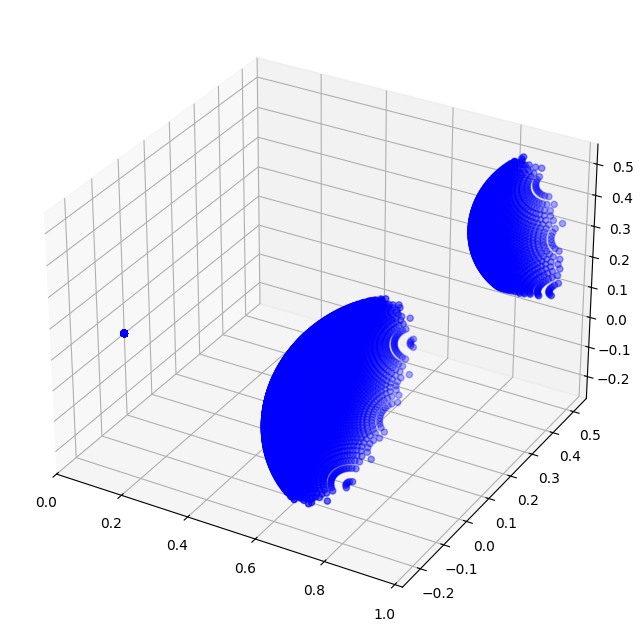

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D # Import for 3D plotting

# Example data for 3D points
# x = np.array([1, 2, 3, 4, 5])
# y = np.array([2, 4, 1, 5, 3])
# z = np.array([5, 3, 4, 2, 1])

x1, y1, z1 = coords1
x2, y2, z2 = coords1

# Filter out non-finite values (NaN, Inf)
finite_mask1 = np.isfinite(x1) & np.isfinite(y1) & np.isfinite(z1)
finite_mask2 = np.isfinite(x2) & np.isfinite(y2) & np.isfinite(z2)

x1_filtered, y1_filtered, z1_filtered = x1[finite_mask1], y1[finite_mask1], z1[finite_mask1]
x2_filtered, y2_filtered, z2_filtered = x2[finite_mask2], y2[finite_mask2], z2[finite_mask2]

# Check if there is any finite data to plot
if x2_filtered.size > 0 and y2_filtered.size > 0 and z2_filtered.size > 0:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # ax.scatter(x1, y1, z1, c='r', marker='o')
    ax.scatter(x2_filtered, y2_filtered, z2_filtered, c='b', marker='o')

    # Print min and max values for debugging
    print(f"x2_filtered min: {np.min(x2_filtered)}, max: {np.max(x2_filtered)}")
    print(f"y2_filtered min: {np.min(y2_filtered)}, max: {np.max(y2_filtered)}")
    print(f"z2_filtered min: {np.min(z2_filtered)}, max: {np.max(z2_filtered)}")


    # Set axis limits explicitly, adding a small offset if min and max are the same
    x_min, x_max = np.min(x2_filtered), np.max(x2_filtered)
    y_min, y_max = np.min(y2_filtered), np.max(y2_filtered)
    z_min, z_max = np.min(z2_filtered), np.max(z2_filtered)

    epsilon = 1e-9 # Small value to ensure a non-zero range

    ax.set_xlim([x_min, x_max if x_max > x_min else x_max + epsilon])
    ax.set_ylim([y_min, y_max if y_max > y_min else y_max + epsilon])
    ax.set_zlim([z_min, z_max if z_max > z_min else z_max + epsilon])


    plt.show()
else:
    print("No finite data to plot for coords2.")

In [ ]:
import pandas as pd

x2, y2, z2 = coords2

# Create a dictionary where keys are column names and values are your numpy arrays
data = {'Column1': x2.flatten(), 'Column2': y2.flatten(), 'Column3': z2.flatten()}

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('output.csv', index=False)

print("Numpy arrays saved to output.csv")

Numpy arrays saved to output.csv


1.2791330566075831

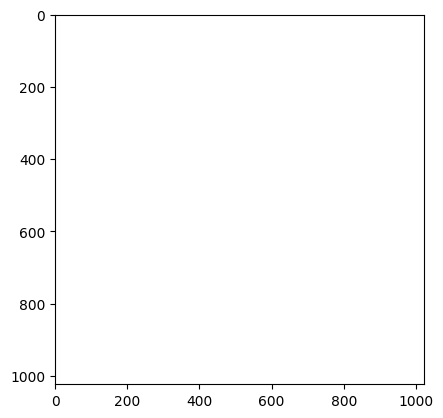

In [ ]:
h = np.expand_dims(n*ld * b, axis=2)
img = np.interp(h, (h.min(), h.max()), (0,1))
plt.imshow(img, cmap="Greys")
x = n[275:400, 600:725]
x[120,0]

In [ ]:
print(test.b[0,0])

AttributeError: 'View' object has no attribute 'b'

In [ ]:
x = np.array([1,2,3])*0.1
x

array([0.1, 0.2, 0.3])

nan